## TODO
- XGBoost i RFC manje senzitivan na outliere
- Napraviti modele za neki parametar (baseline) - XGBOOST, RFC, SVM, (RNN) , LDA, LSTM, GRU (lstm)
- Obaviti oversampling (kako je 95% vremena vrata zatvorena), ponoviti treniranje za najbolji model
- Izbaciti outliere za neki parametar i ponoviti treniranje za najbolji model (boxplot)
- Nekako preppati training data, mozda napraviti derivaciju training date i vidjeti je li model bolji
- Nalaskom najboljeg rezultata za jedan parametar, (uzmi onaj sa najvecom korelacijom u korelacijskoj matrici i sa plottova) to ponovi i za sve ostale parametre
- DOLJE TODOs SU ZA MODEL KOJI KOMBINIRA PARAMETRE KAKO BI NAPRAVIO PREDICTION
- Feature selection kao kombinacija parametara
- https://hal.science/hal-04432021v1/document, feature selection
- "Except for RFC models, features are normalized between 0 and	1 based	on the training	set	characteristics"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
import json

### DATA LOADING AND PREPROCESSING

In [2]:
# Load and preprocess door and window data
door_df = pd.read_csv('datasets/Door_windows.csv')
door_df = door_df.drop('Door_balcony_1st_floor', axis=1)
door_df = door_df.drop_duplicates(subset='Date')
door_df['Date'] = pd.to_datetime(door_df['Date'], format='%d/%m/%Y %H:%M')
door_df = door_df.sort_values('Date')

door_df['Door_Garden'] = door_df['Door_Garden'].map({'on': 1, 'off': 0})
door_df['Door_Hallway'] = door_df['Door_Hallway'].map({'on': 1, 'off': 0})

# Create a new dataframe with 1-second intervals
start_time = door_df['Date'].min()
end_time = door_df['Date'].max()
time_range = pd.date_range(start=start_time, end=end_time, freq='1S')
door_df_1s = pd.DataFrame({'Date': time_range})

# Merge with the original dataframe to fill in missing rows
door_df_1s = pd.merge(door_df_1s, door_df, on='Date', how='left')

# Fill missing values based on the last known status
door_df_1s['Door_Garden'] = door_df_1s['Door_Garden'].fillna(method='ffill')
door_df_1s['Door_Hallway'] = door_df_1s['Door_Hallway'].fillna(method='ffill')
    
# Create a binary state for any door being open
door_df_1s["any_door_open"] = ((door_df_1s["Door_Garden"] == 1) | (door_df_1s["Door_Hallway"] == 1)).astype(int)
door_df_1s['Date'] = pd.to_datetime(door_df_1s['Date'], format='%d/%m/%Y %H:%M')
#door_df_1s.to_csv("datasets/door_windows_combined.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, door_df_1s[["Date", "Door_Garden", "Door_Hallway", "any_door_open"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= start_time]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Filtering out times of experiments being done

In [3]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

# Convert the experiment intervals into a DataFrame
intervals = []
for experiment, times in experiment_data["experiments"].items():
    for time_range in times:
        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})

intervals_df = pd.DataFrame(intervals)

# Filter out rows within the intervals
for _, row in intervals_df.iterrows():
    merged_df = merged_df[
        ~((merged_df['timestamp(ZG)'] >= row['start']) & (merged_df['timestamp(ZG)'] <= row['end']))
    ]
    
merged_df = merged_df.dropna()
#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)

### Visualizing the data

In [4]:
# Visualizing the whole dataset
"""
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(ZG)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(ZG)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of paramaters', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),\n    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),\n    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),\n    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),\n    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),\n    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),\n    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),\n    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')\n]\n\n# Plot each parameter in a separate s

### For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [5]:
# Generating images by days
"""
import os

parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1T').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_plots2"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    open_door_times = day_data[day_data['any_door_open'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(8, 2, figsize=(15, 30))
    fig.suptitle(
        f'Time series of parameters for {day}, red line = garden door open, blue line = hallway door open', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for open_time in open_door_times:
            open_time_door_data = day_data[day_data['timestamp(ZG)'] == open_time]
            if (open_time_door_data['Door_Garden'].values == 1):
                axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.1)
            if (open_time_door_data['Door_Hallway'].values == 1):
                axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.1)
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)
"""

'\nimport os\n\nparameters = [\n    #(\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\n    (\'NetCO2-CO2_ug\', \'NetCO2-CO2 (µg)\'),\n    (\'NetADC_O3-O3_ug\', \'NetADC_O3-O3 (µg)\'),\n    #(\'NetADC_O3-O3(ppb)\', \'NetADC_O3-O3 (ppb)\'),\n    (\'NetADC_CO-CO_ug\', \'NetADC_CO-CO (µg)\'),\n    #(\'NetADC_CO-CO( ppb)\', \'NetADC_CO-CO (ppb)\'),\n    (\'NetPM-PM10(µg/m3)\', \'NetPM-PM10 (µg/m³)\'),\n    (\'NetPM-PM25(µg/m3)\', \'NetPM-PM25 (µg/m³)\'),\n    #(\'NetPid_P1-PPB(ppm)\', \'NetPid_P1-PPB (ppm)\'),\n    (\'NetPid_P1-PPB_ug\', \'NetPid_P1-PPB (µg)\'),\n    (\'NetBME280-PERC(%)\', \'NetBME280 Humidity (%)\'),\n    (\'NetBME280-TEMP_EXT(°C)\', \'NetBME280 Temperature (°C)\'),\n    (\'NetBME280-HPA(hPa)\', \'NetBME280 Pressure (hPa)\'),\n    (\'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2 (µg)\'),\n    (\'NetADC_NO2-NO2(ppb)\', \'NetADC_NO2-NO2 (ppb)\')\n]\n\n# Set the UTC+1 timestamp as the index\nmerged_df.set_index(\'timestamp(ZG)\', inplace=True)\n\n# Resample the data to 1-minute interval

In [6]:
# Code for plotting current days
"""
#20-21 3 min generiranje, u 11.2 sekunde
start_time = '2024-10-29'  
end_time = '2024-10-30'

merged_df.set_index('timestamp(ZG)', inplace=True)
data_resampled = merged_df.resample('1T').mean()
data_resampled = data_resampled.reset_index()

filtered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)

# List of parameters and titles
parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    #('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

open_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

    # Add vertical lines for door open times with color
    for open_time in open_door_times:
        open_time_door_data = filtered_resampled_df[filtered_resampled_df['timestamp(ZG)'] == open_time]
        if (open_time_door_data['Door_Garden'].values == 1):
            axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.1)
        if (open_time_door_data['Door_Hallway'].values == 1):
            axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.1)

# Remove unused subplots if they exist
for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""


"\n#20-21 3 min generiranje, u 11.2 sekunde\nstart_time = '2024-10-29'  \nend_time = '2024-10-30'\n\nmerged_df.set_index('timestamp(ZG)', inplace=True)\ndata_resampled = merged_df.resample('1T').mean()\ndata_resampled = data_resampled.reset_index()\n\nfiltered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]\n\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n   

#### We can see that although the correlation matrix doesn't give the best correlations results there is a clear correlation in the plots between rapid change of co2, 03, co etc. parameters and the door being opened. 
#### Thesis: using derivations (amount of change through time) to predict when the doors are opened. In other words, the doors are definitely opened when there is a bigger change in paramaters. Another thing to note is that we should try other ways of prepping the training data, other than putting it straight in.

### Analysis of data

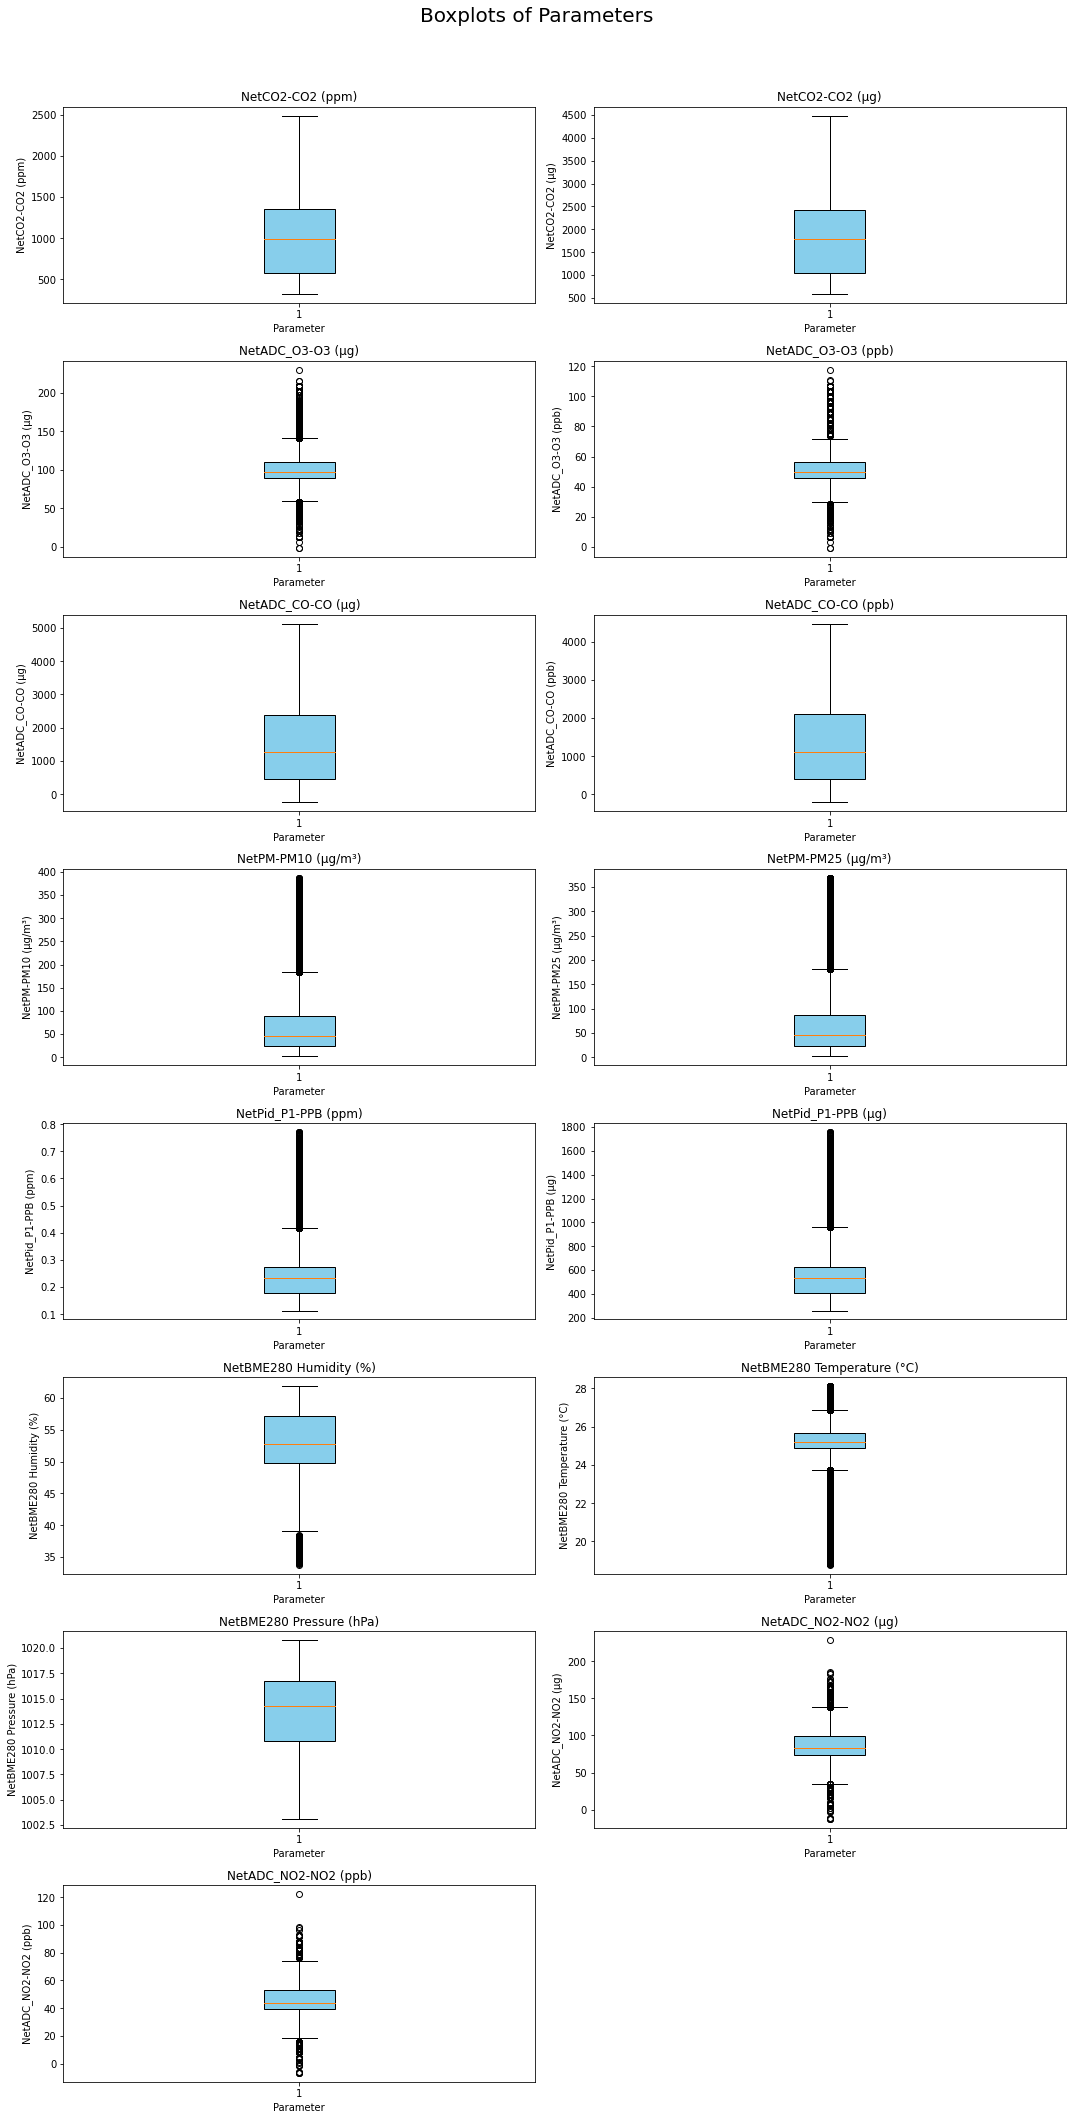

In [7]:
import matplotlib.pyplot as plt

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(merged_df[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

### Outlier analysis

In [8]:
parameters = [
    "NetCO2-CO2(ppm)", "NetCO2-CO2_ug", "NetADC_O3-O3_ug", "NetADC_O3-O3(ppb)", 
    "NetADC_CO-CO_ug", "NetADC_CO-CO( ppb)", "NetPM-PM10(µg/m3)", "NetPM-PM25(µg/m3)", 
    "NetPid_P1-PPB(ppm)", "NetPid_P1-PPB_ug", "NetBME280-PERC(%)", "NetBME280-TEMP_EXT(°C)", 
    "NetBME280-HPA(hPa)", "NetADC_NO2-NO2_ug", "NetADC_NO2-NO2(ppb)"
]

# Initialize dictionaries to store outlier counts and percentages
outlier_counts = {}
outlier_percentages = {}

# Total number of rows in the dataset
total_rows = len(merged_df)

for param in parameters:
    Q1 = merged_df[param].quantile(0.25)
    Q3 = merged_df[param].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = merged_df[(merged_df[param] < lower_bound) | (merged_df[param] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / total_rows) * 100
    
    outlier_counts[param] = outlier_count
    outlier_percentages[param] = outlier_percentage

print("Outlier counts and percentages for each parameter:\n")
for param in parameters:
    print(f"{param}: {outlier_counts[param]} outliers ({outlier_percentages[param]:.2f}%)")

Outlier counts and percentages for each parameter:

NetCO2-CO2(ppm): 0 outliers (0.00%)
NetCO2-CO2_ug: 0 outliers (0.00%)
NetADC_O3-O3_ug: 5284 outliers (1.73%)
NetADC_O3-O3(ppb): 5042 outliers (1.65%)
NetADC_CO-CO_ug: 0 outliers (0.00%)
NetADC_CO-CO( ppb): 0 outliers (0.00%)
NetPM-PM10(µg/m3): 37537 outliers (12.26%)
NetPM-PM25(µg/m3): 36576 outliers (11.94%)
NetPid_P1-PPB(ppm): 1167 outliers (0.38%)
NetPid_P1-PPB_ug: 1167 outliers (0.38%)
NetBME280-PERC(%): 253 outliers (0.08%)
NetBME280-TEMP_EXT(°C): 23915 outliers (7.81%)
NetBME280-HPA(hPa): 0 outliers (0.00%)
NetADC_NO2-NO2_ug: 957 outliers (0.31%)
NetADC_NO2-NO2(ppb): 806 outliers (0.26%)


#### Most outliers are with the NetPM-PM10(µg/m3) and NetPM-PM25(µg/m3) readings, looking at the plots, the readings stay around 10-100 but on Oct 21 - Oct 25, they go up to 300-350, also a higher amount on Oct 30 and 31 with a maximum of around 180

### Correlation matrix, removed ppm/ug readings where applicable, with outliers

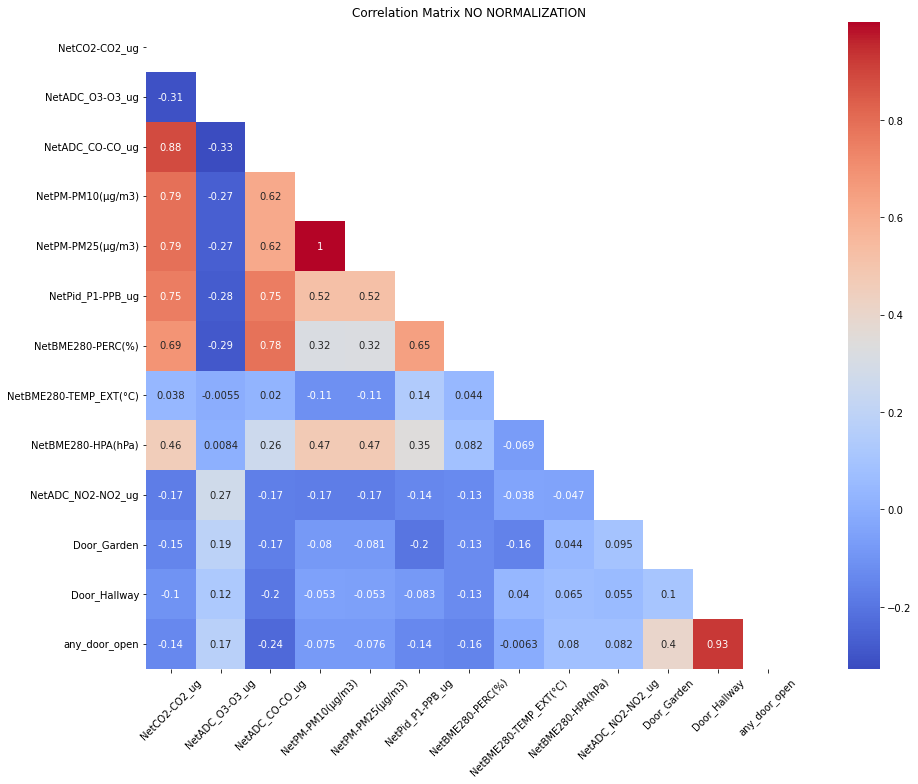

In [9]:
columns_to_consider = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug','NetADC_CO-CO_ug', 'NetPM-PM10(µg/m3)', 
    'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'Door_Garden', 
    'Door_Hallway', 'any_door_open'
]

# Subset the dataframe to include only the desired columns
df_subset = merged_df[columns_to_consider]

# Compute the correlation matrix
correlation_matrix = df_subset.corr()

# Plot the heatmap using seaborn
plt.figure(figsize=(16, 11))
#sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)

# Display the plot
plt.title('Correlation Matrix NO NORMALIZATION')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# MODELS WITH INDIVIDUAL PARAMETERS
#### We will try a couple of different classification models: XGBOOST, RFC, SVM, LDA, LSTM, GRU on NetADC_CO-CO_ug, as it seems to give a strong correlation to door opening, afterwards we will run the best model on the other parameters individually. We are focusing on recall

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(y_pred, y_test, name):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Results for {name}:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("="*50)

### XGBoost

In [11]:
from xgboost import XGBClassifier

X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
evaluate_model(y_pred, X_test, y_test, "XGBoost")

# Train and Evaluate Models Using TimeSeriesSplit
"""
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")
    xgb.fit(X_train, y_train)
    evaluate_model(xgb, X_test, y_test, "XGBoost")
"""

c:\Users\tjura\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for XGBoost:
Accuracy: 0.7438530612244898
F1 Score: 0.10456024199531991
Confusion Matrix:
 [[44645  2818]
 [12871   916]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     47463
         1.0       0.25      0.07      0.10     13787

    accuracy                           0.74     61250
   macro avg       0.51      0.50      0.48     61250
weighted avg       0.66      0.74      0.68     61250



'\nfor train_index, test_index in tscv.split(X):\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    \n    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")\n    xgb.fit(X_train, y_train)\n    evaluate_model(xgb, X_test, y_test, "XGBoost")\n'

### RFC, with resampling F1 17%->27%

In [14]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  # For SMOTE

X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, X_test, y_test, "RFC")

"""
# Train and Evaluate Models Using TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")
    rfc.fit(X_train, y_train)
    evaluate_model(rfc, X_test, y_test, "RFC")
"""

c:\Users\tjura\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Results for RFC:
Accuracy: 0.6810938775510204
F1 Score: 0.27497123343602686
Confusion Matrix:
 [[38013  9450]
 [10083  3704]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.80     47463
         1.0       0.28      0.27      0.27     13787

    accuracy                           0.68     61250
   macro avg       0.54      0.53      0.54     61250
weighted avg       0.68      0.68      0.68     61250



'\n# Train and Evaluate Models Using TimeSeriesSplit\nfor train_index, test_index in tscv.split(X):\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    \n    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")\n    rfc.fit(X_train, y_train)\n    evaluate_model(rfc, X_test, y_test, "RFC")\n'

In [13]:
# Code for plotting only 'NetADC_CO-CO_ug' for current days, with vertical lines for door open times
"""
start_time = '2024-10-29'  
end_time = '2024-10-30'

merged_df.set_index('timestamp(ZG)', inplace=True)
data_resampled = merged_df.resample('1T').mean()
data_resampled = data_resampled.reset_index()

filtered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]

# Set up the figure for a single plot
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('NetADC_CO-CO (µg) over Time', fontsize=16)

# Plot only the 'NetADC_CO-CO_ug' parameter
ax.plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df['NetADC_CO-CO_ug'], label='NetADC_CO-CO (µg)', color='b')

# Add vertical lines only when 'any_door_open' is True
open_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']
for open_time in open_door_times:
    ax.axvline(x=open_time, color='black', linestyle='--', lw=1, alpha=0.05)

predicted_times = filtered_resampled_df.iloc[:len(y_pred)]['timestamp(ZG)']  # Get corresponding timestamps
# Add vertical lines for y_pred = 1 (door open)
for idx, pred in enumerate(y_pred):
    if pred == 1:
        ax.axvline(x=predicted_times.iloc[idx], color='r', linestyle='-', lw=2, alpha=0.05)

# Set axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('NetADC_CO-CO (µg)')

# Rotate x-axis ticks for better visibility
ax.tick_params(axis='x', rotation=45)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\nstart_time = '2024-10-29'  \nend_time = '2024-10-30'\n\nmerged_df.set_index('timestamp(ZG)', inplace=True)\ndata_resampled = merged_df.resample('1T').mean()\ndata_resampled = data_resampled.reset_index()\n\nfiltered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]\n\n# Set up the figure for a single plot\nfig, ax = plt.subplots(figsize=(15, 8))\nfig.suptitle('NetADC_CO-CO (µg) over Time', fontsize=16)\n\n# Plot only the 'NetADC_CO-CO_ug' parameter\nax.plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df['NetADC_CO-CO_ug'], label='NetADC_CO-CO (µg)', color='b')\n\n# Add vertical lines only when 'any_door_open' is True\nopen_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']\nfor open_time in open_door_times:\n    ax.axvline(x=open_time, color='black', linestyle='--', lw=1, alpha=0.05)\n\npredicted_times = filtered_resampled_df.iloc[:len(y_pred)]['t

### SVM

In [14]:
# takes too long to train
"""
from sklearn.svm import SVC

# Support Vector Machine (SVM)
X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
svm = SVC()
svm.fit(X_train, y_train)
evaluate_model(svm, X_test, y_test, "SVM")
"""

'\nfrom sklearn.svm import SVC\n\n# Support Vector Machine (SVM)\nX = merged_df[[\'NetADC_CO-CO_ug\']].values\ny = merged_df[[\'any_door_open\']].values\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)\nsvm = SVC()\nsvm.fit(X_train, y_train)\nevaluate_model(svm, X_test, y_test, "SVM")\n'

### LDA

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X = merged_df[['NetADC_CO-CO_ug']].values
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Linear Discriminant Analysis (LDA)
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
evaluate_model(y_pred, X_test, y_test, "LDA")

c:\Users\tjura\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Results for LDA:
Accuracy: 0.7749061224489796
F1 Score: 0.0
Confusion Matrix:
 [[47463     0]
 [13787     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      1.00      0.87     47463
         1.0       0.00      0.00      0.00     13787

    accuracy                           0.77     61250
   macro avg       0.39      0.50      0.44     61250
weighted avg       0.60      0.77      0.68     61250



c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Data normalization

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)'
]

# Normalize the data
#scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
scaler = StandardScaler()
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])


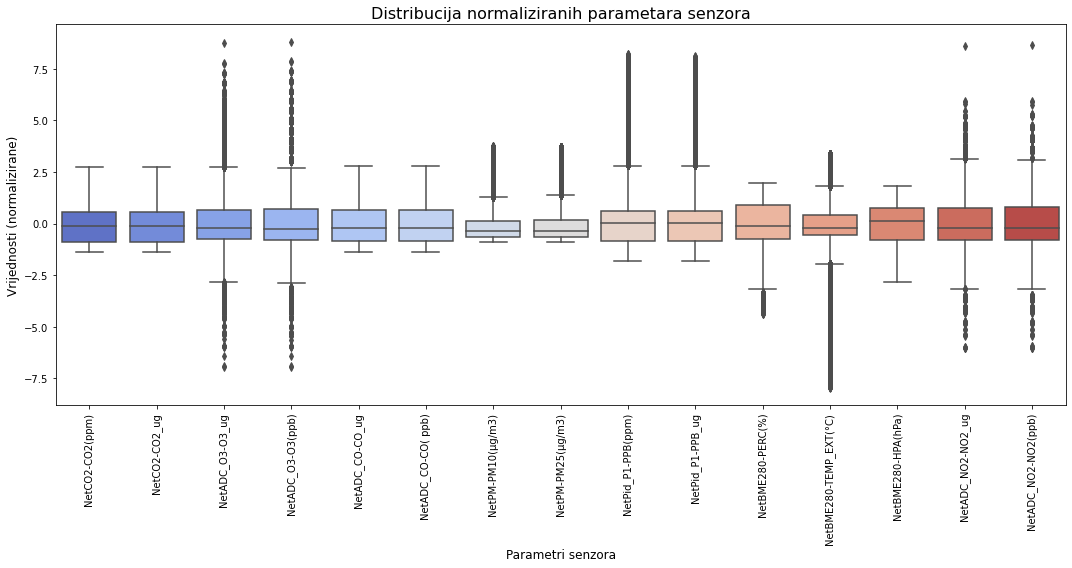

In [17]:
# 1. Prepare the data for plotting
# 'sensor_df_normalized' is your DataFrame with normalized data
data_to_plot = sensor_df_normalized[parameters_to_normalize]

# 2. Plot all parameters as box plots
plt.figure(figsize=(15, 8))  # Set the figure size
sns.boxplot(data=data_to_plot, orient='v', palette='coolwarm')

# 3. Customize the plot
plt.title('Distribucija normaliziranih parametara senzora', fontsize=16)  # Plot title in Croatian
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Parametri senzora', fontsize=12)
plt.ylabel('Vrijednosti (normalizirane)', fontsize=12)

# 4. Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Correlation matrix with normalized data is the same as the corr. matrix with un-normalized data

In [18]:
# Normaliziranje podataka te crtanje korelacijske matrice
"""
from sklearn.preprocessing import MinMaxScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)',
    'Door_Garden', 'Door_Hallway', 'any_door_open'
]

# Normalize the data
scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)'),
    ('Door_Garden', 'Door_Garden')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(sensor_df_normalized[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

# Generate correlation matrix
correlation_matrix = sensor_df_normalized[parameters_to_normalize].corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)
plt.title("Correlation Matrix WITH NORMALIZATION", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\nparameters_to_normalize = [\n    \'NetCO2-CO2(ppm)\', \'NetCO2-CO2_ug\', \'NetADC_O3-O3_ug\',\n    \'NetADC_O3-O3(ppb)\', \'NetADC_CO-CO_ug\', \'NetADC_CO-CO( ppb)\',\n    \'NetPM-PM10(µg/m3)\', \'NetPM-PM25(µg/m3)\', \'NetPid_P1-PPB(ppm)\',\n    \'NetPid_P1-PPB_ug\', \'NetBME280-PERC(%)\', \'NetBME280-TEMP_EXT(°C)\',\n    \'NetBME280-HPA(hPa)\', \'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2(ppb)\',\n    \'Door_Garden\', \'Door_Hallway\', \'any_door_open\'\n]\n\n# Normalize the data\nscaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization\nsensor_df_normalized = merged_df.copy()\nsensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])\n\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle(\'Boxplots of Parameters\', fontsize=20)\n\n# List of parameters and titles\nparameters = [\n    (\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\

## PCA Analysis

In [19]:
from sklearn.decomposition import PCA

parameters_for_PCA = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 
    'NetBME280-TEMP_EXT(°C)', 'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug'
]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(sensor_df_normalized[parameters_for_PCA])

In [19]:
pca_unnormalized = PCA(n_components=10)
X_pca_unnormalized = pca_unnormalized.fit_transform(merged_df[parameters_for_PCA])

### Scree plot

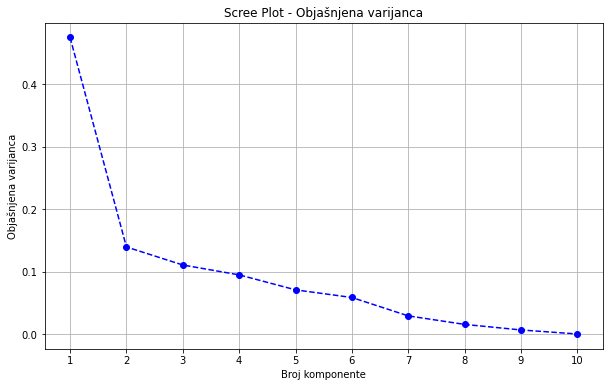

In [20]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
components = np.arange(1, len(pca.explained_variance_ratio_) + 1)  # Component indices
plt.plot(components, pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(components)  # Ensure all components are shown on x-axis
plt.grid()
plt.show()


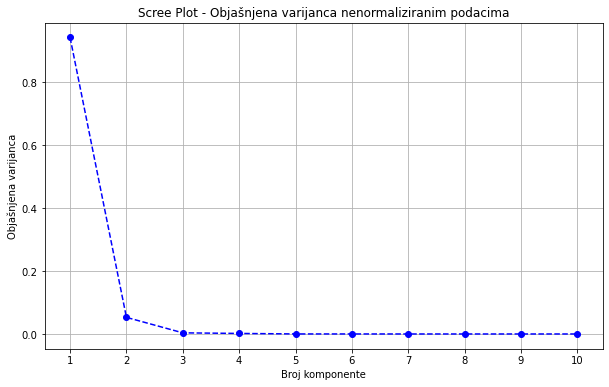

In [21]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
unnormalized_components = np.arange(1, len(pca_unnormalized.explained_variance_ratio_) + 1)  # Component indices
plt.plot(unnormalized_components, pca_unnormalized.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca nenormaliziranim podacima')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(unnormalized_components)  # Ensure all components are shown on x-axis
plt.grid()
plt.show()

### Cumulative Explained Variance

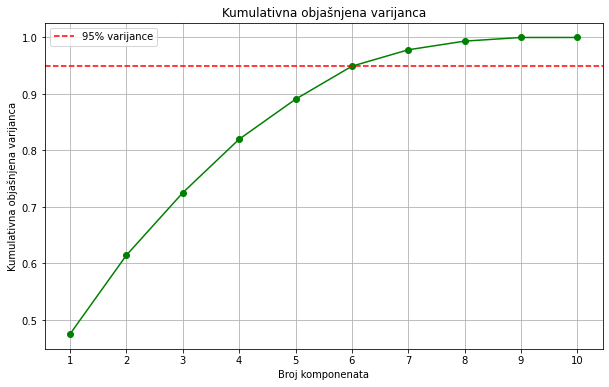

In [22]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()


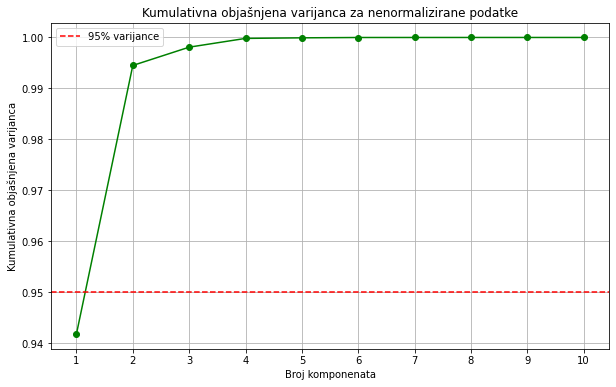

In [23]:
# Cumulative explained variance
unnormalized_cumulative_variance = np.cumsum(pca_unnormalized.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(unnormalized_components, unnormalized_cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca za nenormalizirane podatke')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(unnormalized_components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()

### PCA Loadings (Feature Contribution)

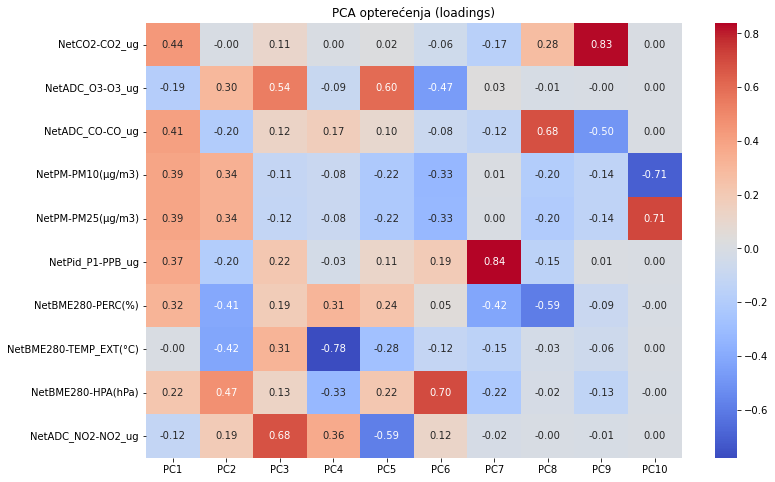

In [24]:
# Extract PCA components (loadings)
loadings = pca.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings)')
plt.show()


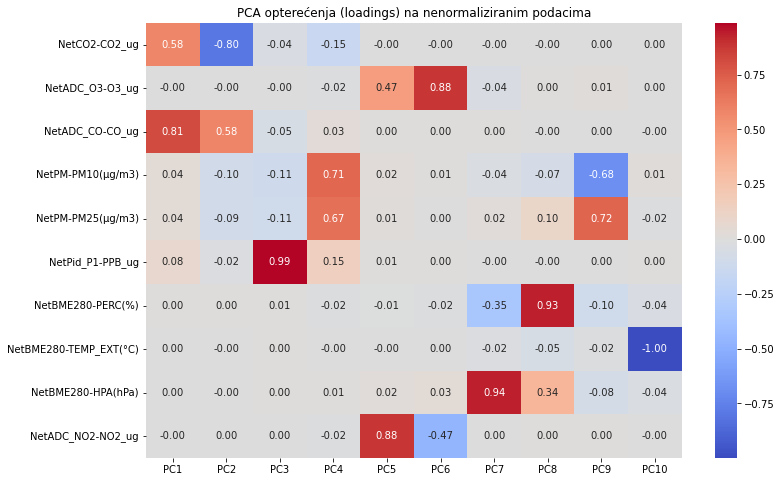

In [25]:
# Extract PCA components (loadings)
unnormalized_loadings = pca_unnormalized.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
unnormalized_loadings_df = pd.DataFrame(unnormalized_loadings, columns=[f'PC{i+1}' for i in range(unnormalized_loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(unnormalized_loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings) na nenormaliziranim podacima')
plt.show()


### Let's try an RFC MODEL with the PCA components

In [31]:
y = merged_df[['any_door_open']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
evaluate_model(y_pred, X_test, y_test, "PCA RFC")

C:\Users\tjura\AppData\Local\Temp/ipykernel_15716/3579412006.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Results for PCA RFC:
Accuracy: 0.783330612244898
F1 Score: 0.3986042506910772
Confusion Matrix:
 [[43581  3882]
 [ 9389  4398]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.92      0.87     47463
         1.0       0.53      0.32      0.40     13787

    accuracy                           0.78     61250
   macro avg       0.68      0.62      0.63     61250
weighted avg       0.76      0.78      0.76     61250



### RFC with PCA, SMOTE

In [24]:
# Step 1: Split the data
X = sensor_df_normalized[parameters_for_PCA]
y = merged_df['any_door_open'].values  # Ensure this is a 1D array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Apply PCA to the resampled training data
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)  # Apply the same PCA transformation to the test set

# Step 4: Train the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_pca, y_train_resampled)

# Step 5: Predict on the PCA-transformed test set
y_pred = rfc.predict(X_test_pca)

evaluate_model(y_pred, y_test, "PCA RFC")

c:\Users\tjura\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tjura\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Results for PCA RFC:
Accuracy: 0.7747918367346939
F1 Score: 0.13991769547325103
Confusion Matrix:
 [[46334  1129]
 [12665  1122]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.98      0.87     47463
         1.0       0.50      0.08      0.14     13787

    accuracy                           0.77     61250
   macro avg       0.64      0.53      0.51     61250
weighted avg       0.72      0.77      0.71     61250



- Handle Class Imbalance:
Use oversampling techniques (e.g., SMOTE, RandomOverSampler) for the minority class.
The model currently favors the majority class (door closed).
- Tune Model Parameters:
Optimize hyperparameters using techniques like Grid Search or Randomized Search.
- Adjust Class Weights:
Penalize misclassification of the minority class to balance the learning.
- Feature Engineering:
Add more features or rolling window statistics (e.g., moving averages) that capture temporal trends.